In [13]:
# Date of creation: 12-12-24
# Author: David Yang

### **Step 1: CpG Methylation Probability Pileup QC**

CpG methylation probability pileups generated by [pb-CpG-tools](https://github.com/PacificBiosciences/pb-CpG-tools) (v2.3.2) can produce incorrect results in two key scenarios where there is a heterozygous variant:

1. **Variant Sites Appearing as Unmethylated CpGs**: When genetic variants disrupt CpG sites, these positions can be misinterpreted as CpGs with 0%/low methylation (>10%) probability. This creates "phantom" unmethylated CpG calls at variant locations. 
2. **Denovo CpG Creation**: Variants can create new CpG sites on one haplotype that don't exist on the other. This leads to incorrect methylation calls when the non-CpG haplotype is interpreted as having unmethylated CpGs.

#### Workflow

**Input Files Required:**
- VCF file containing genetic variants
- Reference FASTA file
- CpG methylation BED files (combined, hap1, hap2)

**Analysis Steps:**
1. Identify variant positions affecting CpG sites
2. Detect destroyed reference CpGs and created denovo CpGs per haplotype
3. Filter methylation calls based on variant effects
4. Generate QC metrics and visualizations

**Output Files:**
- Filtered BED files with problematic sites removed
- Excluded sites BED files
- QC report with filtering statistics
- Distribution plots for passing and excluded sites


### Filter out phantom CpG sites:

In [3]:
        # Define the base directory
base_dir = "/gs/gsfs0/shared-lab/greally-lab/David/AlleleStacker_tests/QC_Comparison/AlleleStacker"

# Construct paths using the base directory
bash_dir = f"{base_dir}/bash/pileup_QC"
sample_list = f"{base_dir}/bash/pileup_QC/sample_list.txt"
config_file = f"{base_dir}/bash/pileup_QC/config.yaml"
output_dir = f"{base_dir}/outputs/pileup_QC"

# Run the filtering script
!sbatch $bash_dir/submit_pileup_qc.sh $sample_list $config_file $output_dir

Submitted batch job 8765205


### Visualize the results of the filtered CpG sites.

In [13]:
# Update paths for summary plots.
import os
base_dir = "/gs/gsfs0/shared-lab/greally-lab/David/AlleleStacker_tests/QC_Comparison/AlleleStacker"
input_dir = f"{base_dir}/outputs/pileup_QC"
output_dir = f"{base_dir}/outputs/pileup_QC/plots"
python_script = f"{base_dir}/python/pileup_QC/summarize_qc.py"

# Run the script
import subprocess
subprocess.run(["python", python_script, "--input-dir", input_dir, "--output-dir", output_dir])

2025-01-07 17:22:45,633 - INFO - Starting CpG plot generation
2025-01-07 17:22:45,914 - INFO - Loaded data from /gs/gsfs0/shared-lab/greally-lab/David/AlleleStacker_tests/QC_Comparison/AlleleStacker/outputs/pileup_QC/SPM320/filtering_summary.csv
2025-01-07 17:22:45,920 - INFO - Loaded data from /gs/gsfs0/shared-lab/greally-lab/David/AlleleStacker_tests/QC_Comparison/AlleleStacker/outputs/pileup_QC/SPM180/filtering_summary.csv
2025-01-07 17:22:45,926 - INFO - Loaded data from /gs/gsfs0/shared-lab/greally-lab/David/AlleleStacker_tests/QC_Comparison/AlleleStacker/outputs/pileup_QC/SPM321/filtering_summary.csv
2025-01-07 17:22:45,933 - INFO - Loaded data from /gs/gsfs0/shared-lab/greally-lab/David/AlleleStacker_tests/QC_Comparison/AlleleStacker/outputs/pileup_QC/SPM161/filtering_summary.csv
2025-01-07 17:22:45,939 - INFO - Loaded data from /gs/gsfs0/shared-lab/greally-lab/David/AlleleStacker_tests/QC_Comparison/AlleleStacker/outputs/pileup_QC/SPM303/filtering_summary.csv
2025-01-07 17:22:4

CompletedProcess(args=['python', '/gs/gsfs0/shared-lab/greally-lab/David/AlleleStacker_tests/QC_Comparison/AlleleStacker/python/pileup_QC/summarize_qc.py', '--input-dir', '/gs/gsfs0/shared-lab/greally-lab/David/AlleleStacker_tests/QC_Comparison/AlleleStacker/outputs/pileup_QC', '--output-dir', '/gs/gsfs0/shared-lab/greally-lab/David/AlleleStacker_tests/QC_Comparison/AlleleStacker/outputs/pileup_QC/plots'], returncode=0)

#### Note
A site is considered "preserved" if it meets these criteria:
- Has high methylation probability (>90%)
- Has good coverage (≥10 reads)
- Was initially marked for exclusion but isn't at a variant position


### Generate plots of the CpG pileup distribution

In [26]:
import os

# Generates a plot per sample which shows the distribution of CpG methylation pileups.

base_dir = "/gs/gsfs0/shared-lab/greally-lab/David/AlleleStacker_tests/QC_Comparison/AlleleStacker"
bash_dir = f"{base_dir}/bash/pileup_QC"
input_dir = f"{base_dir}/outputs/pileup_QC"
output_dir = f"{base_dir}/outputs/pileup_QC/plots"

!sbatch $bash_dir/pileup_distribution.sh $input_dir $output_dir



Submitted batch job 8765383


### **Step 2: Generate segmentation data**


In [2]:
import os
# Run the segmentation script on QCed CpG data
base_dir = "/gs/gsfs0/shared-lab/greally-lab/David/AlleleStacker_tests/QC_Comparison/AlleleStacker"
bash_dir = f"{base_dir}/bash/segmentation"
input_dir = f"{base_dir}/outputs/pileup_QC"
output_dir = f"{base_dir}/outputs/segmentation/QC"

!sbatch $bash_dir/a_segment_samples.sh $input_dir $output_dir


Submitted batch job 8766345


In [3]:

import os
# Run the segmentation script on original CpG data

!sbatch $bash_dir/segment_original.sh



Submitted batch job 8766364


In [6]:
# Parse the segmentation results of the QCed data

base_dir = "/gs/gsfs0/shared-lab/greally-lab/David/AlleleStacker_tests/QC_Comparison/AlleleStacker"
bash_dir = f"{base_dir}/bash/segmentation"
input_dir = f"{base_dir}/outputs/segmentation/QC"
output_dir = f"{base_dir}/outputs/segmentation/QC/regions_by_label"

!sbatch $bash_dir/b_extract-regions.sh $input_dir $output_dir 




Submitted batch job 8766476


In [4]:
# Parse the segmentation results of the original data

!sbatch $bash_dir/extract-original.sh

Submitted batch job 8766398


### Segmentation Plots of QC-ed data

In [10]:
import os
# Summarize the segmentation results for each sample.
# Summary plots of the region counts and region sizes


base_dir = "/gs/gsfs0/shared-lab/greally-lab/David/AlleleStacker_tests/QC_Comparison/AlleleStacker"
bash_dir = f"{base_dir}/bash/segmentation"
input_dir = f"{base_dir}/outputs/segmentation/QC"
output_dir = f"{base_dir}/outputs/segmentation/QC"


!sbatch $bash_dir/plot_segmentation_sample.sh $input_dir $output_dir
!sbatch $bash_dir/plot_segmentation_group.sh $input_dir $output_dir


Submitted batch job 8766480
Submitted batch job 8766481


### Segmentation plots of original data


In [16]:
import os
# Summarize the segmentation results for each sample.
# Summary plots of the region counts and region sizes


base_dir = "/gs/gsfs0/shared-lab/greally-lab/David/AlleleStacker_tests/QC_Comparison/AlleleStacker"
bash_dir = f"{base_dir}/bash/segmentation/no-QC"
input_dir = f"{base_dir}/outputs/segmentation/no-QC"
output_dir = f"{base_dir}/outputs/segmentation/no-QC"


!sbatch $bash_dir/plot_segmentation_sample.sh $input_dir $output_dir
!sbatch $bash_dir/plot_segmentation_group.sh $input_dir $output_dir


Submitted batch job 8766705


Submitted batch job 8766706


#### QC VS No-QC CpG data
The script below generates a heat map comparing the segmentation region summary data (counts and sizes).
- The percentage values are the % difference between the original data and the QC data.

Observations:
SPM282 appears to have been affected by the QC the most,w ehreby the unmethylated region count decreased by ~22%, and the sizes of tehse regions increase by 20%

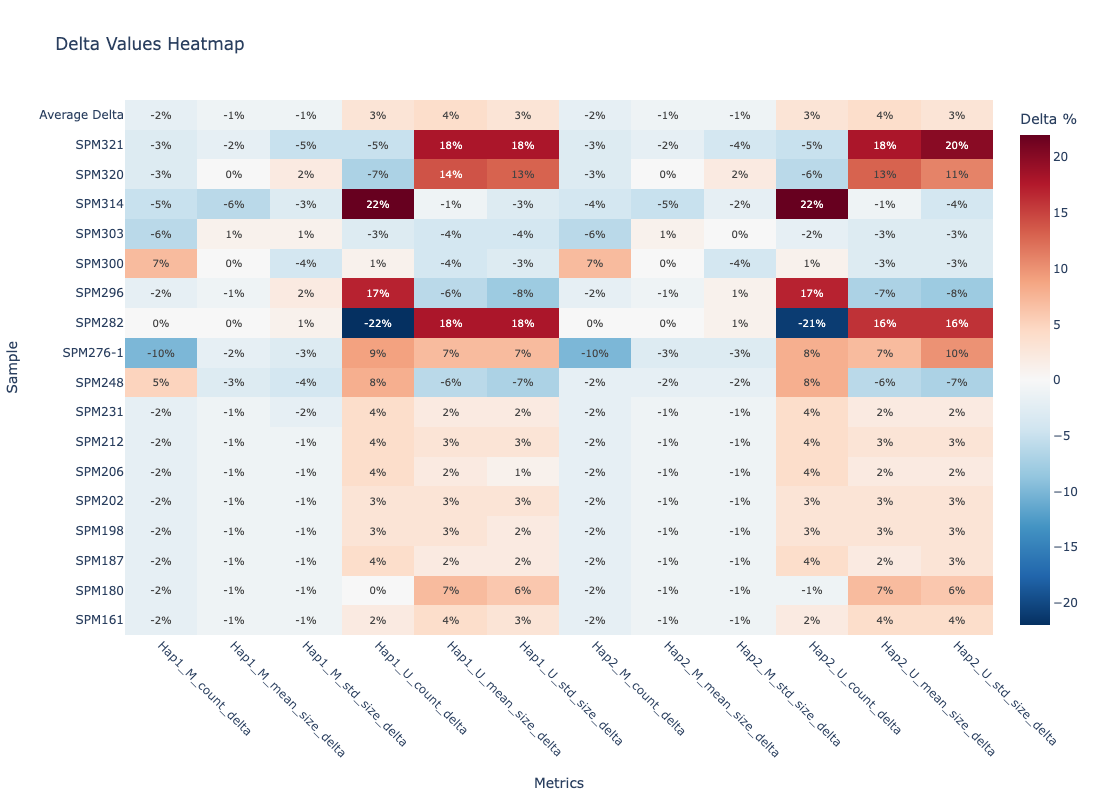

In [6]:
#!/usr/bin/env python3
"""
Generate heatmap visualization from delta values
Usage: python generate_heatmap.py
"""
import plotly.graph_objects as go
import pandas as pd

# Create the data
data = {
    'sample': ['SPM161', 'SPM180', 'SPM187', 'SPM198', 'SPM202', 'SPM206', 'SPM212', 
               'SPM231', 'SPM248', 'SPM276-1', 'SPM282', 'SPM296', 'SPM300', 'SPM303', 
               'SPM314', 'SPM320', 'SPM321', 'Average Delta'],
    'Hap1_M_count_delta': [-2, -2, -2, -2, -2, -2, -2, -2, 5, -10, 0, -2, 7, -6, -5, -3, -3, -2],
    'Hap1_M_mean_size_delta': [-1, -1, -1, -1, -1, -1, -1, -1, -3, -2, 0, -1, 0, 1, -6, 0, -2, -1],
    'Hap1_M_std_size_delta': [-1, -1, -1, -1, -1, -1, -1, -2, -4, -3, 1, 2, -4, 1, -3, 2, -5, -1],
    'Hap1_U_count_delta': [2, 0, 4, 3, 3, 4, 4, 4, 8, 9, -22, 17, 1, -3, 22, -7, -5, 3],
    'Hap1_U_mean_size_delta': [4, 7, 2, 3, 3, 2, 3, 2, -6, 7, 18, -6, -4, -4, -1, 14, 18, 4],
    'Hap1_U_std_size_delta': [3, 6, 2, 2, 3, 1, 3, 2, -7, 7, 18, -8, -3, -4, -3, 13, 18, 3],
    'Hap2_M_count_delta': [-2, -2, -2, -2, -2, -2, -2, -2, -2, -10, 0, -2, 7, -6, -4, -3, -3, -2],
    'Hap2_M_mean_size_delta': [-1, -1, -1, -1, -1, -1, -1, -1, -2, -3, 0, -1, 0, 1, -5, 0, -2, -1],
    'Hap2_M_std_size_delta': [-1, -1, -1, -1, -1, -1, -1, -1, -2, -3, 1, 1, -4, 0, -2, 2, -4, -1],
    'Hap2_U_count_delta': [2, -1, 4, 3, 3, 4, 4, 4, 8, 8, -21, 17, 1, -2, 22, -6, -5, 3],
    'Hap2_U_mean_size_delta': [4, 7, 2, 3, 3, 2, 3, 2, -6, 7, 16, -7, -3, -3, -1, 13, 18, 4],
    'Hap2_U_std_size_delta': [4, 6, 3, 3, 3, 2, 3, 2, -7, 10, 16, -8, -3, -3, -4, 11, 20, 3]
}

# Convert to DataFrame
df = pd.DataFrame(data)

# Create heatmap
fig = go.Figure(data=go.Heatmap(
    z=df.iloc[:, 1:].values,
    x=df.columns[1:],
    y=df['sample'],
    text=df.iloc[:, 1:].values,
    texttemplate='%{text}%',
    textfont={"size": 10},
    colorscale='RdBu_r',
    zmid=0,
    colorbar_title="Delta %"
))

# Update layout
fig.update_layout(
    title='Delta Values Heatmap',
    xaxis_title="Metrics",
    yaxis_title="Sample",
    width=1200,
    height=800,
    xaxis={'tickangle': 45}
)

# Save as HTML file (interactive)
fig.write_html("heatmap.html")

# Show plot in notebook
fig.show()

### **Step 3: Generate candidate regions of interest**

These are generated by aggregating overlapping unmethylated regions across samples 

In [31]:
# Generate the consensus regions for the QC data

base_dir = "/gs/gsfs0/shared-lab/greally-lab/David/AlleleStacker_tests/QC_Comparison/AlleleStacker"
bash_dir = f"{base_dir}/bash/candidate_regions"
input_dir = f"{base_dir}/outputs/segmentation/QC/regions_by_label/regions"
output_dir = f"{base_dir}/outputs/candidate_regions/QC/pre-filter"

!sbatch $bash_dir/a_consensus_regions.sh $input_dir $output_dir

Submitted batch job 8880266


QC candidate region summary:

H1 Statistics:
Average number of regions per sample: 75022.35 ± 10555.37
Average region size across samples: 749.45 ± 95.52
Consensus regions: 205253 regions
Consensus region size: 1004.91 ± 853.61

H2 Statistics:
Average number of regions per sample: 74935.18 ± 10593.65
Average region size across samples: 748.02 ± 94.27
Consensus regions: 205402 regions
Consensus region size: 999.74 ± 843.86

In [26]:
# Generate the consensus regions for the no-QC data

base_dir = "/gs/gsfs0/shared-lab/greally-lab/David/AlleleStacker_tests/QC_Comparison/AlleleStacker"
bash_dir = f"{base_dir}/bash/candidate_regions"
input_dir = f"{base_dir}/outputs/segmentation/no-QC/regions_by_label"
output_dir = f"{base_dir}/outputs/candidate_regions/no-QC/pre-filter"

!sbatch $bash_dir/a_consensus_regions.sh $input_dir $output_dir

Submitted batch job 8880252


no-QC candidate region summary:
H1 Statistics:
Average number of regions per sample: 76923.47 ± 11355.56
Average region size across samples: 774.60 ± 90.45
Consensus regions: 228619 regions
Consensus region size: 1006.24 ± 861.71

H2 Statistics:
Average number of regions per sample: 76851.35 ± 11411.47
Average region size across samples: 773.28 ± 89.50
Consensus regions: 228659 regions
Consensus region size: 1002.55 ± 852.45


### Filter candidate regions to generate refined candidate loci based on the overlap with contiguous methylated regions.


In [34]:
# Filter QC candidate regions to generate refined candidate loci
import os

base_dir = "/gs/gsfs0/shared-lab/greally-lab/David/AlleleStacker_tests/QC_Comparison/AlleleStacker"
bash_dir = f"{base_dir}/bash/candidate_regions"
candidate_dir = f"{base_dir}/outputs/candidate_regions/QC/pre-filter"
seg_region_dir = f"{base_dir}/outputs/segmentation/QC/regions_by_label/regions"
output_dir = f"{base_dir}/outputs/candidate_regions/QC/filtered"

print(bash_dir)

!sbatch $bash_dir/b_filter-consensus.sh $candidate_dir $seg_region_dir $output_dir H1
!sbatch $bash_dir/b_filter-consensus.sh $candidate_dir $seg_region_dir $output_dir H2

/gs/gsfs0/shared-lab/greally-lab/David/AlleleStacker_tests/QC_Comparison/AlleleStacker/bash/candidate_regions
Submitted batch job 8880267
Submitted batch job 8880268


In [36]:
# Filter candidate regions to generate refined candidate loci
import os

base_dir = "/gs/gsfs0/shared-lab/greally-lab/David/AlleleStacker_tests/QC_Comparison/AlleleStacker"
bash_dir = f"{base_dir}/bash/candidate_regions"
candidate_dir = f"{base_dir}/outputs/candidate_regions/no-QC/pre-filter"
seg_region_dir = f"{base_dir}/outputs/segmentation/no-QC/regions_by_label"
output_dir = f"{base_dir}/outputs/candidate_regions/no-QC/filtered"

!sbatch $bash_dir/b_filter-consensus.sh $candidate_dir $seg_region_dir $output_dir H1
!sbatch $bash_dir/b_filter-consensus.sh $candidate_dir $seg_region_dir $output_dir H2




Submitted batch job 8880283
Submitted batch job 8880284


### **Step 4: Generate IGV viewable files**
For visualizing our candidate regions and variants, we will need to aggregate, format, and colorize the 2 datasets generated:
- Individual sample data
- Candidate regions

Files generated:

- allele_stacks :  IGV colorized bed files of each sample's segmentation regions organized by haplotype.
- candidate_regions : IGV colorized bed files of the candidate regions

In [25]:
# Generate allele stacks of the QC-ed segmentation by aggregating the segmentation data for each sample

# Set up paths
base_dir = "/gs/gsfs0/shared-lab/greally-lab/David/AlleleStacker_tests/QC_Comparison/AlleleStacker"
bash_dir = f"{base_dir}/bash/igv_viewing"
INPUT_DIR=f"{base_dir}/outputs/segmentation/QC/regions_by_label/regions"
OUTPUT_DIR=f"{base_dir}/outputs/igv_beds/QC/cohort_regions"


!sbatch $bash_dir/a_IGV_all-samples.sh $INPUT_DIR $OUTPUT_DIR


Submitted batch job 8947184


In [27]:
# Generate IGV beds for the QC candidate regions

# Set up paths
base_dir = "/gs/gsfs0/shared-lab/greally-lab/David/AlleleStacker_tests/QC_Comparison/AlleleStacker"
bash_dir = f"{base_dir}/bash/igv_viewing"
INPUT_DIR=f"{base_dir}/outputs/candidate_regions/QC/filtered"
OUTPUT_DIR=f"{base_dir}/outputs/igv_beds/QC/candidate_regions"


!sbatch $bash_dir/b_consensus-IGV.sh $INPUT_DIR $OUTPUT_DIR


Submitted batch job 8947186


In [29]:
# Create BED files for IGV viewing each sample's H1 and H2 segments

# Define paths

base_dir = "/gs/gsfs0/shared-lab/greally-lab/David/AlleleStacker_tests/QC_Comparison/AlleleStacker"
bash_dir = f"{base_dir}/bash/igv_viewing"
input_dir=f"{base_dir}/outputs/segmentation/QC/regions_by_label/regions"
output_dir=f"{base_dir}/outputs/igv_beds/QC/sample_segmentation"

!sbatch $bash_dir/c_IGV-segmentation.sh $input_dir $output_dir



Submitted batch job 8947188


### **Step 5: Prepare VCFs for variant mapping**
This requires merging each sample's VCF for each variant type into a cohort wide VCF.
* Adjust file paths within each bash script

Each VCF was QC'ed with the following parameters for this run :


Merging:
bcftools merge
    --force-samples \
    --merge both \
    --file-list "$FILEPATHS" \
    --output-type z \

Small variants:
bcftools filter -i 'QUAL>=20 && DP>=10' 
bcftools annotate --set-id '%CHROM:%POS:%REF:%ALT'

SVs:
bcftools filter -i 'FILTER="PASS" && DP>=10'
bcftools annotate --set-id '%CHROM:%POS:%REF:%ALT:%SVANN'

CNVs:
bcftools filter -i 'QUAL>=20 && FILTER="PASS"
bcftools annotate --set-id '%CHROM:%POS:%REF:%ALT:%SVLEN' 

Tandem Repeats:
bcftools filter -i 'QUAL>=20 && FILTER="PASS"'
bcftools annotate --set-id '%CHROM:%POS:%REF:%ALT'

In [6]:

# Set up environment
import os
import sys

# Set up paths
bash_dir = "/gs/gsfs0/shared-lab/greally-lab/David/AlleleStacker_tests/QC_Comparison/AlleleStacker/bash"
bash_current = os.path.join(bash_dir, "variant_map")   

In [7]:
# merge each VCF type into a single cohort vcf using bcftools merge
# small variants
FILEPATHS="/gs/gsfs0/shared-lab/greally-lab/David/AlleleStacker_tests/QC_Comparison/AlleleStacker/bash/variant_map/file_paths/filepaths_small.txt"
OUT_DIR="/gs/gsfs0/shared-lab/greally-lab/David/AlleleStacker_tests/QC_Comparison/AlleleStacker/outputs/variant_mapping/merged_variants/small_variants"


!sbatch $bash_current/a_merge_small_vars.sh $FILEPATHS $OUT_DIR

Submitted batch job 8765225


In [8]:
# merge structural variants

FILEPATHS="/gs/gsfs0/shared-lab/greally-lab/David/AlleleStacker_tests/QC_Comparison/AlleleStacker/bash/variant_map/file_paths/filepaths_SVs.txt"
OUT_DIR="/gs/gsfs0/shared-lab/greally-lab/David/AlleleStacker_tests/QC_Comparison/AlleleStacker/outputs/variant_mapping/merged_variants/structural_variants"


!sbatch $bash_current/b_merge_sv_vars.sh $FILEPATHS $OUT_DIR

Submitted batch job 8765226


In [9]:
# merge copy number variants
FILEPATHS="/gs/gsfs0/shared-lab/greally-lab/David/AlleleStacker_tests/QC_Comparison/AlleleStacker/bash/variant_map/file_paths/filepaths_CNVs.txt"
OUT_DIR="/gs/gsfs0/shared-lab/greally-lab/David/AlleleStacker_tests/QC_Comparison/AlleleStacker/outputs/variant_mapping/merged_variants/copy_number_variants"

!sbatch $bash_current/c_merge_CNVs_vars.sh $FILEPATHS $OUT_DIR

Submitted batch job 8765227


In [10]:
# merge tandem repeats

FILEPATHS="/gs/gsfs0/shared-lab/greally-lab/David/AlleleStacker_tests/QC_Comparison/AlleleStacker/bash/variant_map/file_paths/filepaths_repeats.txt"

OUT_DIR="/gs/gsfs0/shared-lab/greally-lab/David/AlleleStacker_tests/QC_Comparison/AlleleStacker/outputs/variant_mapping/merged_variants/trgt_repeat_vcf"

!sbatch $bash_current/d_merge_repeats_vars.sh  $FILEPATHS $OUT_DIR

# none remained after QC, omitted for now  

Submitted batch job 8765228


### Step 6: Map variants to regions

#### Haplotype-Specific Variant Mapping Analysis

Overview
Maps genetic variants to haplotype-specific methylated/unmethylated regions. Processes phased variants (SNPs, SVs) and unphased variants (CNVs, tandem repeats) from VCF files against methylation BED files.

Input Requirements
- BED file with methylation regions containing:
  - Chromosome, start, end positions
  - `methylated_samples` and `unmethylated_samples` columns
- Indexed VCF files (.vcf.gz + .tbi) for variants:
  - Small variants (SNPs/indels)
  - Copy number variants
  - Structural variants  
  - Tandem repeats

Output Format
Tab-separated file with columns:
```
chrom         Chromosome
start         Region start position
end           Region end position
variant_id    Unique variant identifier 
type          Variant type (small/cnv/sv/tr)
ref           Reference allele
alt           Alternative allele
num_meth      Number of samples with variant + methylated
num_unmeth    Number of samples with variant + unmethylated
meth_samples  Methylated samples with variant: sample:genotype
unmeth_samples Unmethylated samples with variant: sample:genotype
```
Haplotype Assignment
- Phased variants (small, sv): Uses `|`-separated genotypes, checking H1 (idx 0) or H2 (idx 1)
- Unphased variants (cnv, tr): Reports any non-reference genotype



### Run a test for 1,000 regions

In [4]:

# Set up environment
import os
import sys

# Set up paths
base_dir = "/gs/gsfs0/shared-lab/greally-lab/David/AlleleStacker_tests/QC_Comparison/AlleleStacker"
bash_dir ="/gs/gsfs0/shared-lab/greally-lab/David/AlleleStacker_tests/1-14-25/AlleleStacker/bash/variant_map"
BED_DIR=f"{base_dir}/outputs/candidate_regions/QC/filtered/test_1k_regions"
VARIANT_DIR=f"{base_dir}/outputs/variant_mapping/merged_variants"
PYTHON_DIR="/gs/gsfs0/shared-lab/greally-lab/David/AlleleStacker_tests/1-14-25/AlleleStacker/python/variant_map"
OUTPUT_DIR="/gs/gsfs0/shared-lab/greally-lab/David/AlleleStacker_tests/1-14-25/AlleleStacker/outputs/variant_mapping/1k_regions"  

# SUBMIT THE JOB
!sbatch $bash_dir/test_map.sh $BED_DIR $VARIANT_DIR $PYTHON_DIR $OUTPUT_DIR

Submitted batch job 8948423


### Run for all regions

In [34]:

# Set up environment
import os
import sys

# Set up paths
base_dir = "/gs/gsfs0/shared-lab/greally-lab/David/AlleleStacker_tests/QC_Comparison/AlleleStacker"
bash_dir ="/gs/gsfs0/shared-lab/greally-lab/David/AlleleStacker_tests/1-14-25/AlleleStacker/bash/variant_map"
BED_DIR=f"{base_dir}/outputs/candidate_regions/QC/filtered"
VARIANT_DIR=f"{base_dir}/outputs/variant_mapping/merged_variants"
PYTHON_DIR="/gs/gsfs0/shared-lab/greally-lab/David/AlleleStacker_tests/1-14-25/AlleleStacker/python/variant_map"
OUTPUT_DIR="/gs/gsfs0/shared-lab/greally-lab/David/AlleleStacker_tests/1-14-25/AlleleStacker/outputs/variant_mapping/all_regions"  

# SUBMIT THE JOB
!sbatch $bash_dir/test_map.sh $BED_DIR $VARIANT_DIR $PYTHON_DIR $OUTPUT_DIR

Submitted batch job 8947197


### Mermaid format diagram of the variant mapper logic 

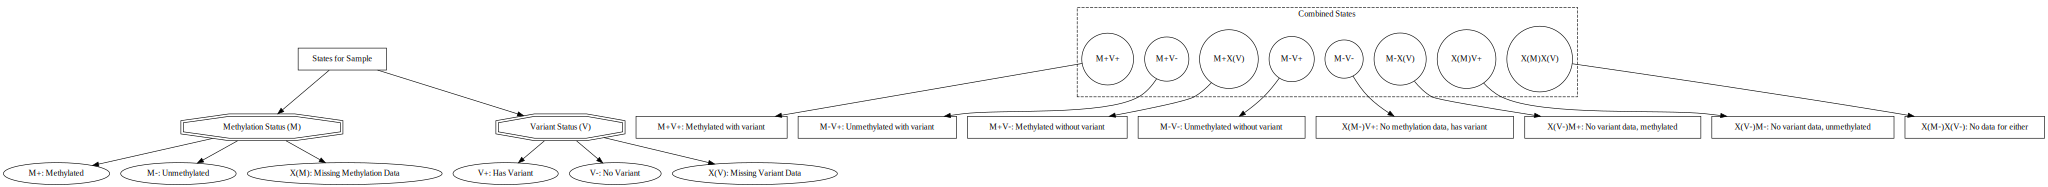

In [4]:

import graphviz

# Create directed graph
dot = graphviz.Digraph('Methylation and Variant States', 
                       comment='Sample State Diagram',
                       graph_attr={'rankdir': 'TD'})

# Main states
dot.node('A', 'States for Sample', shape='box')
dot.node('B', 'Methylation Status (M)', shape='doubleoctagon')
dot.node('C', 'Variant Status (V)', shape='doubleoctagon')

# Methylation states
dot.node('B1', 'M+: Methylated')
dot.node('B2', 'M-: Unmethylated')
dot.node('B3', 'X(M): Missing Methylation Data')

# Variant states
dot.node('C1', 'V+: Has Variant')
dot.node('C2', 'V-: No Variant')
dot.node('C3', 'X(V): Missing Variant Data')

# Connect main nodes
dot.edge('A', 'B')
dot.edge('A', 'C')
dot.edge('B', 'B1')
dot.edge('B', 'B2')
dot.edge('B', 'B3')
dot.edge('C', 'C1')
dot.edge('C', 'C2')
dot.edge('C', 'C3')

# Create subgraph for combined states
with dot.subgraph(name='cluster_0') as c:
    c.attr(label='Combined States', style='dashed')
    for state in [
        ('D1', 'M+V+'), ('D2', 'M+V-'), ('D3', 'M+X(V)'),
        ('D4', 'M-V+'), ('D5', 'M-V-'), ('D6', 'M-X(V)'),
        ('D7', 'X(M)V+'), ('D8', 'X(M)X(V)')
    ]:
        c.node(state[0], state[1], shape='circle')

# Add descriptions
descriptions = {
    'G1': 'M+V+: Methylated with variant',
    'G2': 'M-V+: Unmethylated with variant',
    'G3': 'M+V-: Methylated without variant',
    'G4': 'M-V-: Unmethylated without variant',
    'G5': 'X(M-)V+: No methylation data, has variant',
    'G6': 'X(V-)M+: No variant data, methylated',
    'G7': 'X(V-)M-: No variant data, unmethylated',
    'G8': 'X(M-)X(V-): No data for either'
}

# Add description nodes and connect
for i, (key, desc) in enumerate(descriptions.items(), 1):
    dot.node(key, desc, shape='box')
    dot.edge(f'D{i}', key)

# Display graph
dot

In [21]:
# First diagram: State relationships
def create_state_diagram():
    dot = graphviz.Digraph('Methylation and Variant States',
                          comment='Sample State Diagram',
                          graph_attr={'rankdir': 'TB', 'nodesep': '0.5', 'ranksep': '0.7'})

    # Main states in top rank
    with dot.subgraph(name='cluster_top') as top:
        top.attr(rank='source')
        top.node('A', 'States for Sample', shape='box')

    # Methylation and Variant status in second rank
    with dot.subgraph() as second:
        second.attr(rank='same')
        second.node('B', 'Methylation Status (M)', shape='doubleoctagon')
        second.node('C', 'Variant Status (V)', shape='doubleoctagon')

    # Connect main to second rank
    dot.edge('A', 'B')
    dot.edge('A', 'C')

    # Individual states in third rank
    with dot.subgraph() as third:
        third.attr(rank='same')
        # Methylation states
        third.node('B1', 'M+: Methylated')
        third.node('B2', 'M-: Unmethylated')
        third.node('B3', 'X(M): Missing Methylation Data')
        # Variant states
        third.node('C1', 'V+: Has Variant')
        third.node('C2', 'V-: No Variant')
        third.node('C3', 'X(V): Missing Variant Data')

    # Connect states
    dot.edge('B', 'B1')
    dot.edge('B', 'B2')
    dot.edge('B', 'B3')
    dot.edge('C', 'C1')
    dot.edge('C', 'C2')
    dot.edge('C', 'C3')

    # Combined states at bottom
    with dot.subgraph(name='cluster_combined') as c:
        c.attr(label='Combined States', style='dashed')
        c.attr(rank='sink')
        states = [
            ('D1', 'M+V+'), ('D2', 'M+V-'), ('D3', 'M+X(V)'),
            ('D4', 'M-V+'), ('D5', 'M-V-'), ('D6', 'M-X(V)'),
            ('D7', 'X(M)V+'), ('D8', 'X(M)X(V)')
        ]
        for state in states:
            c.node(state[0], state[1], shape='circle')

    return dot

# Second diagram: Scoring Logic
def create_scoring_diagram():
    dot = graphviz.Digraph('Methylation Scoring Logic',
                          comment='Scoring System Diagram',
                          graph_attr={'rankdir': 'TB', 'nodesep': '0.8', 'ranksep': '1.0'})

    # State descriptions with scoring implications
    descriptions = {
        'G1': '''M+V+ State
• Methylated with variant
• Primary contributor to methylation score
• Weight: 40% of ratio''',
        
        'G2': '''M-V+ State
• Unmethylated with variant
• Primary contributor to unmethylation score
• Weight: 60% of inverse ratio''',
        
        'G3': '''Baseline States (M+V-, M-V-)
• Used for ratio denominators
• Define expected methylation patterns''',
        
        'G4': '''Missing Data States
• X(M)V+: Reduces confidence
• X(V)M+/-, X(M)X(V): Not scored'''
    }

    # Add state descriptions
    with dot.subgraph(name='cluster_states') as s:
        s.attr(label='State Contributions', style='dashed')
        for key, desc in descriptions.items():
            s.node(key, desc, shape='box')

    # Add scoring components
    with dot.subgraph(name='cluster_scoring') as s:
        s.attr(label='Scoring System', style='dashed')
        
        s.node('S1', '''Methylation Score Components
------------------------
1. Methylation Ratio (R_m)
   M+V+ samples / Total M+ samples
   Weight: 0.4

2. Unmethylation Protection (R_u)
   1 - (M-V+ samples / Total M- samples)
   Weight: 0.6

3. Statistical Significance
   -0.1 * log10(p-value)''', shape='note')
        
        s.node('S2', '''Confidence Weighting
------------------------
• High (>80%): 1.0
• Medium (>60%): 0.7
• Low (>40%): 0.4
• Very Low: 0.1''', shape='note')
        
        s.node('S3', '''Final Score Calculation
------------------------
Score = confidence_weight * 
(0.4*R_m + 0.6*(1-R_u)) - 
0.1*log10(p-value)''', shape='note')

    # Connect components
    dot.edge('G1', 'S1')
    dot.edge('G2', 'S1')
    dot.edge('S1', 'S3')
    dot.edge('S2', 'S3')

    return dot

# Create both diagrams
state_diagram = create_state_diagram()
scoring_diagram = create_scoring_diagram()

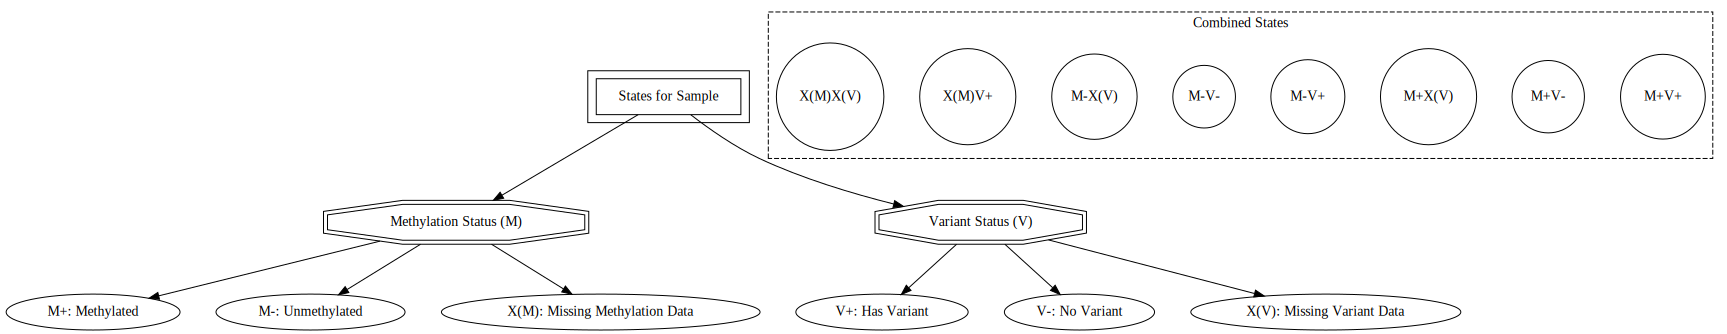

In [22]:
# To show state diagram:
state_diagram

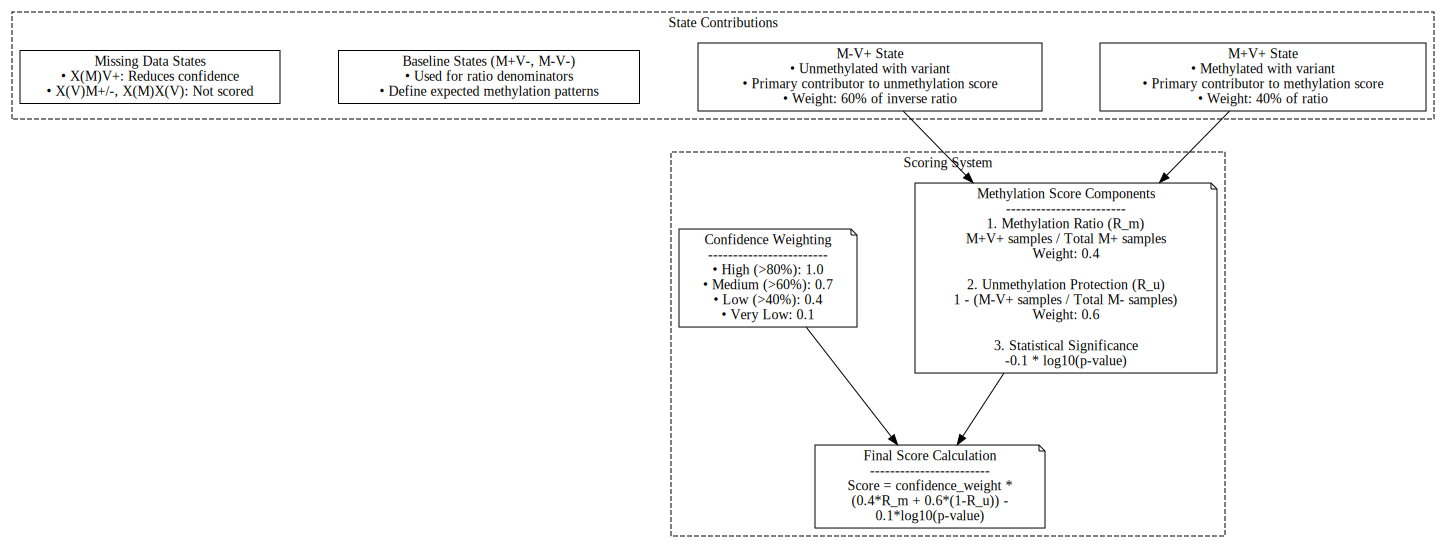

In [23]:
# To show scoring diagram:
scoring_diagram

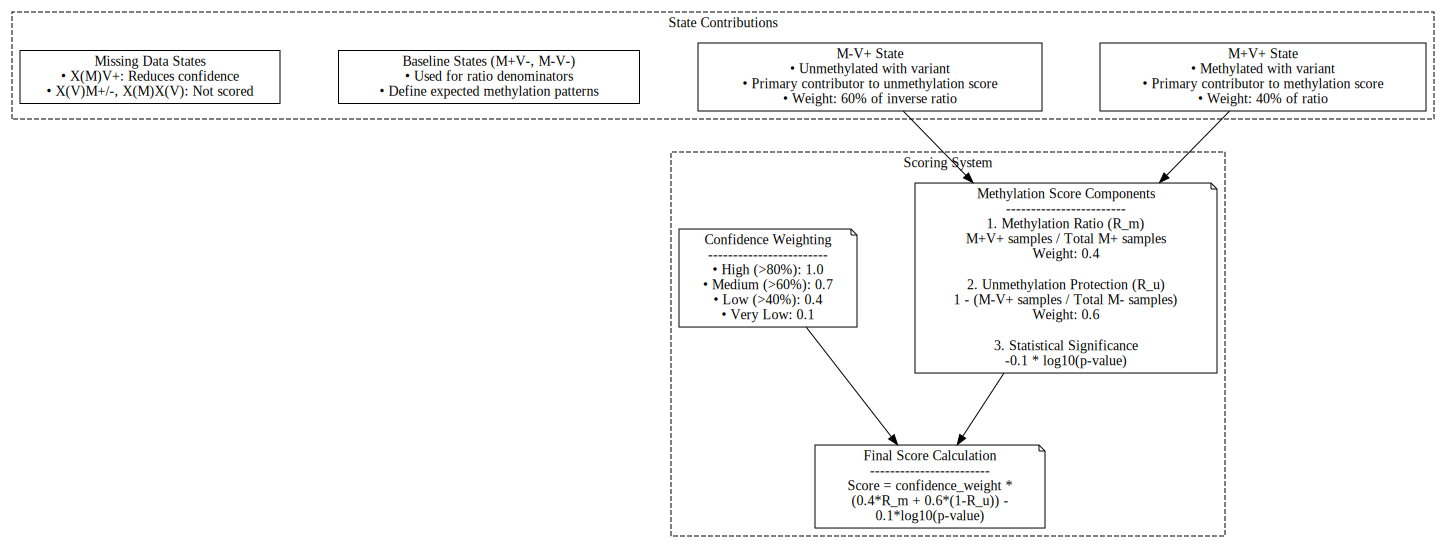